# Testing the Relational Graphlet Convolution Module on SET

In [1]:
import os
import itertools
import numpy as np
import sklearn.model_selection
import sklearn.metrics

# import wandb

import tensorflow as tf

from tqdm.auto import tqdm, trange

# %load_ext autoreload
# %autoreload 2
# from relational_neural_networks.relational_neural_networks import *
import sys; sys.path.append('../..')
import set_game
from relational_neural_networks import utils

2023-06-21 20:36:23.659755: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-21 20:36:24.995069: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Generate dataset for SET

In [2]:
X, y = set_game.create_Xy_data(encode=True)
class_names = ['non-set', 'set']

In [3]:
import imblearn.under_sampling
resampler = imblearn.under_sampling.RandomUnderSampler()
res_idx, y_res = resampler.fit_resample(np.array(range(len(y))).reshape(-1,1), y)
X_res = np.array(X)[np.squeeze(res_idx)]

In [4]:
num_extra_attrs = 3 # number of additional spurious attributes to add
num_vals = 3 # num of possible values per additional attribute

def generate_spurious_attr_card_suffix(num_cards, num_attrs, num_vals):

    attr_vals = np.random.randint(0, num_vals,  size=num_cards)
    additional_card_attrs = np.zeros(shape=(num_cards, num_vals))
    additional_card_attrs[np.arange(num_cards), attr_vals] = 1

    for attr in range(1, num_attrs):
        attr_i_vals = np.random.randint(0, num_vals, size=num_cards)
        attr_i_enc = np.zeros(shape=(num_cards, num_vals))
        attr_i_enc[np.arange(num_cards), attr_i_vals] = 1
        additional_card_attrs = np.concatenate([additional_card_attrs, attr_i_enc], axis=1)

    return additional_card_attrs

def generate_spurious_attr_triplet_suffix(num_triplets, num_extra_attrs, num_vals):
    return np.stack([generate_spurious_attr_card_suffix(num_triplets, num_extra_attrs, num_vals) for _ in range(3)], axis=1)

# generate 'data suffix' (additional spurious attributes for each triplet of cards)
data_suffix = generate_spurious_attr_triplet_suffix(len(X_res), num_extra_attrs, num_vals)

# append spurious attribute to X
X_res_w_spurious = np.concatenate([X_res, data_suffix], axis=-1)

In [5]:
data_suffix.shape, X_res_w_spurious.shape

((12960, 3, 9), (12960, 3, 21))

In [6]:
X_train, y_train, X_val, y_val, X_test, y_test = utils.train_val_test_split(X_res_w_spurious, y_res, test_size=0.4, val_size=0.1)

In [7]:
y_val = tf.one_hot(y_val, 2)
y_test = tf.one_hot(y_test, 2)

batch_size = 256
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

2023-06-21 20:36:31.475983: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-21 20:36:31.476082: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: c37n02.grace.hpc.yale.internal
2023-06-21 20:36:31.476109: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: c37n02.grace.hpc.yale.internal
2023-06-21 20:36:31.476329: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 520.61.5
2023-06-21 20:36:31.476435: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 520.61.5
2023-06-21 20:36:31.476458: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 520.61.5


In [8]:
def sample_train_ds(X_train, y_train, sample_size, batch_size=batch_size):
    sample_idx = np.random.choice(len(y_train), size=sample_size, replace=False)
    X_train_ = X_train[sample_idx]
    y_train_ = y_train[sample_idx]
    y_train_ = tf.one_hot(y_train_, 2)
    train_ds = tf.data.Dataset.from_tensor_slices((X_train_, y_train_)).batch(batch_size)
    return train_ds

In [9]:
print(f'# of training samples:   {len(y_train): 5}')
print(f'# of validation samples: {len(y_val): 5}')
print(f'# of testing samples:    {len(y_test): 5}')

# of training samples:    6479
# of validation samples:  1297
# of testing samples:     5184


## Modeling (RelConvNet)

In [10]:
from relational_neural_networks.multi_head_relation import *
from relational_neural_networks.relational_graphlet_convolution import *

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
create_opt = lambda: tf.keras.optimizers.Adam()
metrics = [
        tf.keras.metrics.BinaryAccuracy(name='acc'),
        tf.keras.metrics.Precision(class_id=1, name='precision'),
        tf.keras.metrics.Recall(class_id=1, name='recall'),
        tf.keras.metrics.AUC(curve='ROC', multi_label=True, name='auc')
        ]

def create_callbacks():
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', start_from_epoch=50, patience=20, verbose=1)
    ]

    return callbacks

In [11]:
mhr = MultiHeadRelation(rel_dim=4, proj_dim=4, symmetric=True)
rel_conv = RelationalGraphletConvolution(
    n_filters=4, graphlet_size=3,
    symmetric_inner_prod=True, groups_type='combinations',
    permutation_aggregator='max', name='rgc')

model = tf.keras.Sequential(
    [
        mhr,
        rel_conv,
        tf.keras.layers.Flatten(name='flatten'),
        tf.keras.layers.Dense(2, name='output')],
    name='rel_conv_net')

model.build(input_shape=(None, *X_train.shape[1:])); # build model
model.compile(loss=loss, optimizer=create_opt(), metrics=metrics)
model.summary()

Model: "rel_conv_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 multi_head_relation (MultiH  (None, 3, 3, 4)          352       
 eadRelation)                                                    
                                                                 
 rgc (RelationalGraphletConv  (None, 1, 4)             144       
 olution)                                                        
                                                                 
 flatten (Flatten)           (None, 4)                 0         
                                                                 
 output (Dense)              (None, 2)                 10        
                                                                 
Total params: 506
Trainable params: 506
Non-trainable params: 0
_________________________________________________________________


In [12]:
y_train.shape, y_test.shape

((6479,), TensorShape([5184, 2]))

In [13]:
train_ds = sample_train_ds(X_train, y_train, 1500)

history = model.fit(train_ds, validation_data=val_ds, epochs=200, callbacks=create_callbacks())

Epoch 1/200


2023-06-21 20:36:33.553963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [1500,2]
	 [[{{node Placeholder/_1}}]]
2023-06-21 20:36:33.944903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/Max_grad/add/Max/reduction_indices' with dtype int32
	 [[{{node gradients/Max_grad/add/Max/reduction_indices}}]]


1/6 [====>.........................] - ETA: 20s - loss: 0.7203 - acc: 0.5117 - precision: 0.5938 - recall: 0.1545 - auc: 0.5161

2023-06-21 20:36:37.681419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [1297,2]
	 [[{{node Placeholder/_1}}]]


6/6 [==============================] - 5s 175ms/step - loss: 0.7103 - acc: 0.5053 - precision: 0.5423 - recall: 0.1029 - auc: 0.5161 - val_loss: 0.7155 - val_acc: 0.5027 - val_precision: 0.6000 - val_recall: 0.0555 - val_auc: 0.4836
Epoch 2/200
6/6 [==============================] - 0s 14ms/step - loss: 0.6987 - acc: 0.5040 - precision: 0.5789 - recall: 0.0441 - auc: 0.5315 - val_loss: 0.7069 - val_acc: 0.5035 - val_precision: 0.6190 - val_recall: 0.0401 - val_auc: 0.4853
Epoch 3/200
6/6 [==============================] - 0s 15ms/step - loss: 0.6917 - acc: 0.5017 - precision: 0.5758 - recall: 0.0254 - auc: 0.5423 - val_loss: 0.7019 - val_acc: 0.5008 - val_precision: 0.5217 - val_recall: 0.0185 - val_auc: 0.4910
Epoch 4/200
6/6 [==============================] - 0s 15ms/step - loss: 0.6871 - acc: 0.4997 - precision: 0.5263 - recall: 0.0134 - auc: 0.5519 - val_loss: 0.6991 - val_acc: 0.5015 - val_precision: 0.6364 - val_recall: 0.0108 - val_auc: 0.4966
Epoch 5/200
6/6 [==================

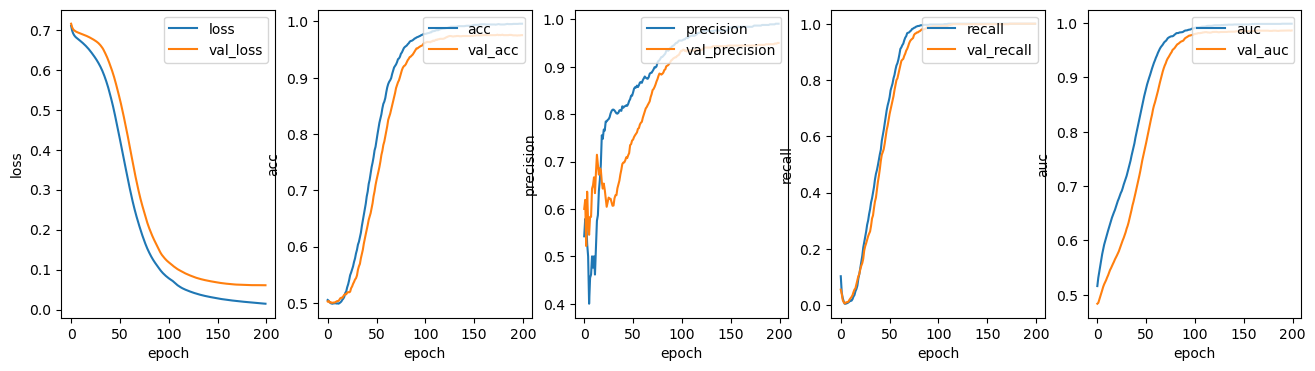

In [14]:
utils.plot_history(history, plot_attrs=('loss', 'acc', 'precision', 'recall', 'auc'), figsize=(16, 4));

In [15]:
model.evaluate(test_ds, return_dict=True)

21/21 [==============================] - 0s 3ms/step - loss: 0.0566 - acc: 0.9796 - precision: 0.9543 - recall: 0.9988 - auc: 0.9868


2023-06-21 20:37:00.003956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [5184,2]
	 [[{{node Placeholder/_1}}]]


{'loss': 0.05659016966819763,
 'acc': 0.9796489477157593,
 'precision': 0.9542941451072693,
 'recall': 0.9988425970077515,
 'auc': 0.9867751598358154}

## Compare to LSTM

In [16]:

model = tf.keras.Sequential(
    [
        tf.keras.layers.LSTM(128),
        tf.keras.layers.Dense(2, name='output')],
    name='lstm')

model.build(input_shape=(None, *X_train.shape[1:])); # build model
model.compile(loss=loss, optimizer=create_opt(), metrics=metrics)
model.summary()

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               76800     
                                                                 
 output (Dense)              (None, 2)                 258       
                                                                 
Total params: 77,058
Trainable params: 77,058
Non-trainable params: 0
_________________________________________________________________


2023-06-21 20:37:00.456256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-21 20:37:00.458228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-21 20:37:00.459708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [17]:
train_ds = sample_train_ds(X_train, y_train, 1500)

history = model.fit(train_ds, validation_data=val_ds, epochs=200, callbacks=create_callbacks())

Epoch 1/200


2023-06-21 20:37:00.651240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [1500,2]
	 [[{{node Placeholder/_1}}]]
2023-06-21 20:37:00.888455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-21 20:37:00.890549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor '

6/6 [==============================] - ETA: 0s - loss: 0.6950 - acc: 0.8720 - precision: 0.9543 - recall: 0.7782 - auc: 0.9182 

2023-06-21 20:37:03.763444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-21 20:37:03.765701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-21 20:37:03.767468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 4s 200ms/step - loss: 0.6950 - acc: 0.8720 - precision: 0.9543 - recall: 0.7782 - auc: 0.9182 - val_loss: 0.6951 - val_acc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4827
Epoch 2/200
6/6 [==============================] - 0s 23ms/step - loss: 0.6907 - acc: 0.5000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5316 - val_loss: 0.6963 - val_acc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4962
Epoch 3/200
6/6 [==============================] - 0s 23ms/step - loss: 0.6886 - acc: 0.5000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5467 - val_loss: 0.6958 - val_acc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4875
Epoch 4/200
6/6 [==============================] - 0s 27ms/step - loss: 0.6862 - acc: 0.5000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5606 - val_loss: 0.6969 - val_acc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+

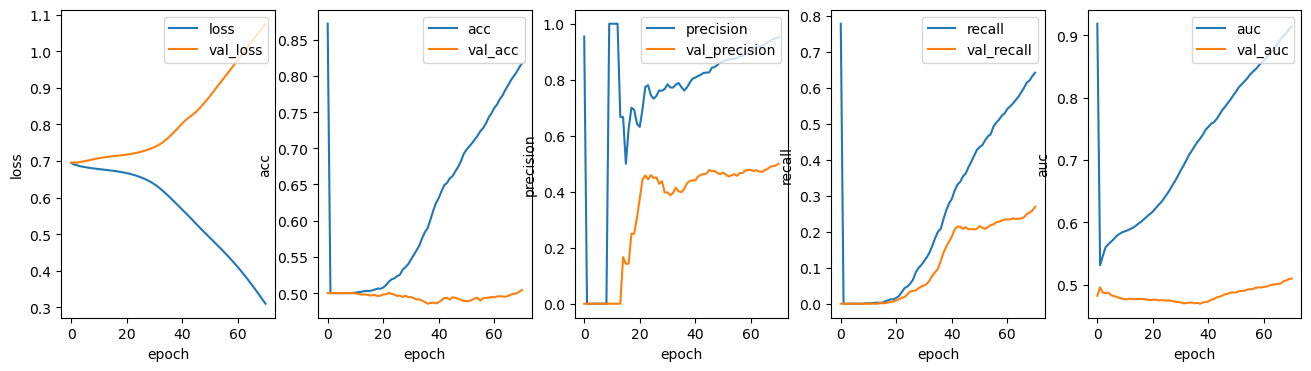

In [18]:
utils.plot_history(history, plot_attrs=('loss', 'acc', 'precision', 'recall', 'auc'), figsize=(16, 4));

In [19]:
model.evaluate(test_ds, return_dict=True)

21/21 [==============================] - 0s 7ms/step - loss: 1.0456 - acc: 0.5181 - precision: 0.5344 - recall: 0.3090 - auc: 0.5248


{'loss': 1.0455900430679321,
 'acc': 0.5181326866149902,
 'precision': 0.5343562364578247,
 'recall': 0.3090277910232544,
 'auc': 0.5247572660446167}

## Compare to Transformer

In [20]:
# use tensorflow_models implementation
import tensorflow_models as tfm

encoder = tfm.nlp.models.TransformerEncoder(
    num_layers=1,
    num_attention_heads=8,
    intermediate_size=32,
    activation='relu',
    dropout_rate=0.0,
    attention_dropout_rate=0.0,
    use_bias=False,
    norm_first=True,
    norm_epsilon=1e-06,
    intermediate_dropout=0.0
)

model = tf.keras.Sequential([encoder, tf.keras.layers.GlobalAveragePooling1D(), tf.keras.layers.Dense(2)])
model.build(input_shape=(None, *X_train.shape[1:])); # build model
model.compile(loss=loss, optimizer=create_opt(), metrics=metrics)
model.summary()

/gpfs/gibbs/project/lafferty/ma2393/conda_envs/relml/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer_encoder (Transf  (None, 3, 21)            2867      
 ormerEncoder)                                                   
                                                                 
 global_average_pooling1d (G  (None, 21)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 2)                 44        
                                                                 
Total params: 2,911
Trainable params: 2,911
Non-trainable params: 0
_________________________________________________________________


In [21]:
train_ds = sample_train_ds(X_train, y_train, 1500)

history = model.fit(train_ds, validation_data=val_ds, epochs=200, callbacks=create_callbacks())

Epoch 1/200


2023-06-21 20:37:20.052983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [1500,2]
	 [[{{node Placeholder/_1}}]]


6/6 [==============================] - 3s 133ms/step - loss: 0.8256 - acc: 0.5147 - precision: 0.5236 - recall: 0.3293 - auc: 0.5185 - val_loss: 0.7479 - val_acc: 0.5139 - val_precision: 0.5160 - val_recall: 0.5223 - val_auc: 0.5231
Epoch 2/200
6/6 [==============================] - 0s 21ms/step - loss: 0.7590 - acc: 0.5127 - precision: 0.5000 - recall: 0.5168 - auc: 0.5040 - val_loss: 0.7282 - val_acc: 0.5139 - val_precision: 0.5147 - val_recall: 0.5393 - val_auc: 0.5159
Epoch 3/200
6/6 [==============================] - 0s 21ms/step - loss: 0.7279 - acc: 0.5180 - precision: 0.5128 - recall: 0.5128 - auc: 0.5130 - val_loss: 0.7215 - val_acc: 0.5042 - val_precision: 0.5047 - val_recall: 0.4977 - val_auc: 0.5120
Epoch 4/200
6/6 [==============================] - 0s 22ms/step - loss: 0.7146 - acc: 0.5140 - precision: 0.5139 - recall: 0.4953 - auc: 0.5187 - val_loss: 0.7168 - val_acc: 0.5085 - val_precision: 0.5144 - val_recall: 0.5223 - val_auc: 0.5114
Epoch 5/200
6/6 [==================

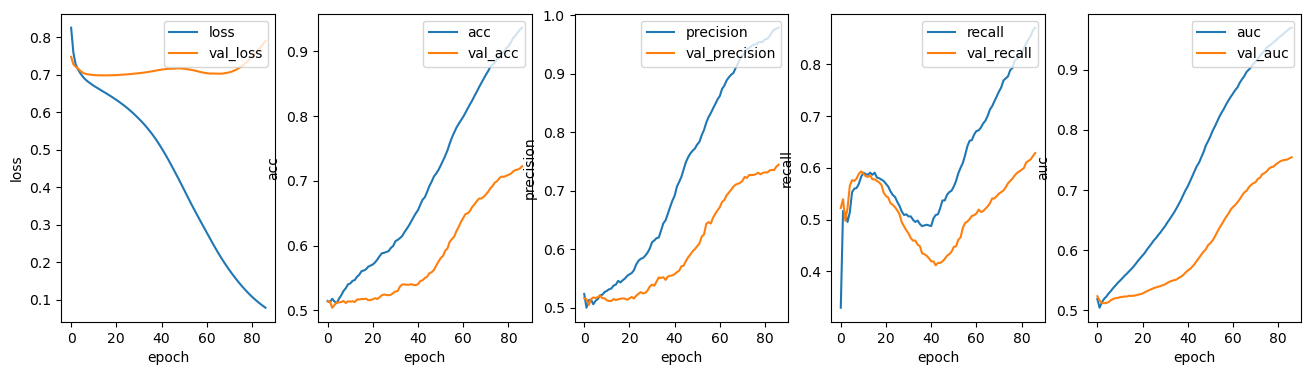

In [22]:
utils.plot_history(history, plot_attrs=('loss', 'acc', 'precision', 'recall', 'auc'), figsize=(16, 4))

In [23]:
model.evaluate(test_ds, return_dict=True)

21/21 [==============================] - 0s 6ms/step - loss: 0.8155 - acc: 0.7221 - precision: 0.7521 - recall: 0.6273 - auc: 0.7500


{'loss': 0.8154726624488831,
 'acc': 0.722125768661499,
 'precision': 0.7520813941955566,
 'recall': 0.6273148059844971,
 'auc': 0.7500242590904236}